# Naive Bayes Classification
# Alex Hobeychi

In [335]:
import pandas as pd
from math import log10
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [336]:
df = pd.read_csv('../data/hns_2018_2019.csv', index_col='Unnamed: 0')

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Object ID           10000 non-null  int64  
 1   Title               10000 non-null  object 
 2   Post Type           10000 non-null  object 
 3   Author              10000 non-null  object 
 4   Created At          10000 non-null  object 
 5   URL                 9420 non-null   object 
 6   Points              10000 non-null  int64  
 7   Number of Comments  10000 non-null  float64
 8   year                10000 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 781.2+ KB


In [419]:
df.head(15)

,Object ID,Title,Post Type,Author,Created At,URL,Points,Number of Comments,year,Formatted Year
0,16043981,Terminal: How the airport came to embody our n...,poll,jseliger,2018-01-01 00:59:56,http://www.slate.com/articles/business/cover_s...,97,73.0,2018,2018
1,16044958,"Not only is it possible to beat Google, it cou...",poll,Nuzzerino,2018-01-01 06:16:27,https://www.quora.com/Is-it-possible-to-beat-G...,92,125.0,2018,2018
2,16045440,DC’s war on rats goes digital,poll,fern12,2018-01-01 09:37:22,https://wamu.org/story/17/12/18/d-c-s-war-rats...,31,53.0,2018,2018
3,16048365,Show HN: Bitcoin Arbitrage – Kraken vs. GDAX,poll,BigBalli,2018-01-01 22:21:21,http://giacomoballi.com/crypto.html,11,6.0,2018,2018
4,16050632,Handy function for Bash to display the compile...,poll,ikromin,2018-01-02 08:19:13,https://www.igorkromin.net/index.php/2018/01/0...,2,0.0,2018,2018
5,16050939,Is debate around 'bias in AI' driven by human ...,poll,imartin2k,2018-01-02 09:49:43,http://donaldclarkplanb.blogspot.com/2017/12/i...,1,0.0,2018,2018
6,16051647,Cryptocurrencies Are Not a Legal Tender; India...,poll,techaddict009,2018-01-02 13:15:06,https://cryptocrimson.com/cryptocurrencies-not...,2,0.0,2018,2018
7,16051717,Tech's Winning (and Losing) Jobs in 2018,poll,SunTzu9087,2018-01-02 13:30:45,https://insights.dice.com/2018/01/02/tech-winn...,1,0.0,2018,2018
8,16051971,Build a URL Shortener Using AWS Lambda and S3,poll,dan9408,2018-01-02 14:27:29,https://medium.freecodecamp.org/how-to-build-a...,1,0.0,2018,2018
9,16052727,Mobile web usage finally tops desktop in December,poll,gator-io,2018-01-02 16:15:39,https://netmarketshare.com/device-market-share...,2,1.0,2018,2018


Lets Feature Engineer the Created At column to get the year from it

In [378]:
def getYear(str):
    return int(str.split('-')[0])

df['Formatted Year'] = df['Created At'].apply(getYear)

In [379]:
df['Formatted Year'].value_counts()

2019    5000
2018    5000
Name: Formatted Year, dtype: int64

## Now let's form our train and test Split  

### First lets split the given title with their post type and year 

In [380]:
TRAIN_YEAR = 2018
TEST_YEAR = 2019
DOCUMENT_TYPES = df['Post Type'].unique()

In [381]:
DOCUMENT_TYPES

array(['poll', 'story', 'ask_hn', 'show_hn'], dtype=object)

## Lets Define a Function that will allow us to genrate training and testing data for us

#### training 

In [382]:
def generateTrainData():
    originalTrainData = []
    for type in DOCUMENT_TYPES:
        tmp =  df[(df['Post Type'] == type) & (df['Formatted Year'] == TRAIN_YEAR)]['Title']
        originalTrainData.append(list(tmp))
    return originalTrainData.copy()

#### testing

In [383]:
def generateTestData():
    originalTestData = []
    for type in DOCUMENT_TYPES:
        tmp =  df[(df['Post Type'] == type) & (df['Formatted Year'] == TEST_YEAR)]['Title']
        originalTestData.append(list(tmp))
    return originalTestData.copy()

## Eventually we'll remove stop words so lets read them from the file and store them in a list

In [384]:
stopwords = [line.rstrip('\n') for line in open('../data/stopwords.txt')]

## We need to define our classes and datastructures that will help us to store and count all the different words we have

### The dictionary class which will contain the unique words for for each Post type

In [385]:
class Dictionary:   

    def __init__(self, type):
        self.titleCount = 0
        self.numberOfWords = 0
        self.vocabulary = {}
        self.TYPE = type
        
    def addWord(self, str):
        if str in self.vocabulary:
            self.vocabulary[str] += 1
        else:
            self.vocabulary[str] = 1

        self.numberOfWords += 1

    def containsWord(self, str):
        if str in self.vocabulary:
            return True
        else:
            return False

    def getWordOccurences(self, str):
        if str in self.vocabulary:
            return self.vocabulary[str]
        else:
            return 0

    def getProbability(self, word, numberOfUniqueWords, smoothing = 0.5):
        if(word in self.vocabulary):
            return (self.vocabulary[word] + smoothing)/(self.numberOfWords + numberOfUniqueWords*smoothing)
        else:
            return smoothing/(self.numberOfWords + numberOfUniqueWords*smoothing)

    def increaseTitleCount(self):
        self.titleCount += 1

    def removeElements(self, threshold = 0, percentage = False):
        thres = 0
        if(percentage):
            frequencies = np.array(list(self.vocabulary.values()))
            thres = np.quantile(frequencies, 1-threshold/100.0)
        else:
            thres = threshold

        newDict = {}
        newNumberOfWords = 0
        newVocabulary = set()
        for key, val in self.vocabulary.items():
            if percentage and val > thres:
                continue
            if not percentage and val < thres:
                continue
            newDict[key] = val
            newNumberOfWords += val
            
        self.vocabulary = newDict
        self.numberOfWords = newNumberOfWords

### The Lexicon class which will contain the references to all the dictionaries

In [386]:
class Lexicon:
    
    def __init__(self, *args):
        self.dictionaries = []
        self.numberOfUniqueWords = 0
        
        for dictionary in args:
            self.dictionaries.append()
        self.updateNumberOfUniqueWords()

    def getOccurences(self, str):
        occurences = {}
        for dictionary in self.dictionaries:
            type = dictionary.TYPE
            occurences[type] = dictionary.getWordOccurences(str)
        return occurences

    def addDictionary(self, dictionary):
        self.dictionaries.append(dictionary)
        self.updateNumberOfUniqueWords()

    def updateNumberOfUniqueWords(self):
        tempDict = {}
        for dictionary in self.dictionaries:
            tempDict.update(dictionary.vocabulary)
        self.numberOfUniqueWords = len(tempDict)

    def removeLeastFrequent(self, threshold, percentage = False):
        numberOfTotalWords = 0
        newSetOfWords = set()
        for dictionary in self.dictionaries:
            dictionary.removeElements(threshold, percentage)
            newSetOfWords = newSetOfWords.union(set(list(dictionary.vocabulary.keys())))
        self.updateNumberOfUniqueWords()
        return newSetOfWords    
    
    def getInformation(self):
        print('\nNumber Of Unique Words in the lexicon: {}\n'.format(self.numberOfUniqueWords))
        for dictionary in self.dictionaries:
            print('------{}------'.format(dictionary.TYPE))
            print('Number Of Unique Words: {}'.format(len(dictionary.vocabulary)))
            print('Number Of Words: {}'.format(dictionary.numberOfWords))
            print('Title Count: {} \n'.format(dictionary.titleCount))

    def getTotalNumberOfWords(self):
        number = 0
        for dictionary in self.dictionaries:
            number += dictionary.numberOfWords
        return number

### The Evaluation class which help evaluate the model

In [387]:
class Evaluation:

        def __init__(self):
            self.typeList = {}
            self.types = {}
            self.predictionMatrix = 0
            self.totalObservations = 0

        def addType(self, types):
            index = 0
            for type in types:
                self.typeList[type] = index 
                index += 1
                self.types[type] = 0
            self.predictionMatrix = np.zeros((len(types),len(types)))

        def incrementType(self, type):
            self.types[type] += 1
            self.totalObservations += 1

        def addPrediction(self, actualType, predictedType):
            indexY = self.getIndex(actualType)
            indexX = self.getIndex(predictedType)
            self.predictionMatrix[indexY][indexX] += 1

        def getTotalPredictions(self):
            return np.sum(self.predictionMatrix)

        def getCorrectPredictions(self):
            return np.trace(self.predictionMatrix)

        def resetPredictions(self):
            size = self.predictionMatrix.shape[0]
            self.predictionMatrix = np.zeros((size,size))

        def getIndex(self, type):
            return self.typeList[type]

        def getAccuracy(self):
            return self.getCorrectPredictions() / self.getTotalPredictions()
        
        def getPrecision(self):
            size = self.predictionMatrix.shape[0]
            precision = np.zeros(size)
            for columnIndex in range(size):
                col = self.predictionMatrix[:, columnIndex]
                colPrecision = self.predictionMatrix[columnIndex,columnIndex] / col.sum()
                precision[columnIndex]= colPrecision
            return precision

        def getAveragePrecision(self):
            precision = self.getPrecision()
            return np.mean(precision)

        def getRecall(self):
            size = self.predictionMatrix.shape[0]
            recall = np.zeros(size)
            for rowIndex in range(size):
                row = self.predictionMatrix[rowIndex,:]
                rowRecall = self.predictionMatrix[rowIndex,rowIndex] / row.sum()
                recall[rowIndex]= rowRecall
            return recall

        def getAverageRecall(self):
            recall = self.getRecall()
            return np.mean(recall)

        def getF1Score(self):
            return 2*(self.getAverageRecall()*self.getAveragePrecision())/\
            (self.getAverageRecall()+self.getAveragePrecision())

        def getMetrics(self):
            return [self.getAccuracy(),self.getAveragePrecision(), self.getAverageRecall(),self.getF1Score()]

### BayesModel class which will contain all the previously defined classed as will allow us to interact with them.

In [388]:
class BayesModel:

    def __init__(self, data, removeStopWords = False , min = -1, max = float('inf')):
        self.train(data, removeStopWords, min, max)
    
    def train(self, data, removeStopWords = False , min = -1, max = float('inf')):
        self.min = min
        self.max = max
        self.totalNumberOfTitles = 0
        self.removeStopWords = removeStopWords
        self.evaluation = Evaluation()
        self.setOfWords = set()
        self.lexicon = self.formLexicon(data)

    def formLexicon(self,data):
        lexicon = Lexicon()
        for x in range(len(data)):
            documentType = DOCUMENT_TYPES[x]
            dictionary = Dictionary(documentType)
            self.evaluation.addType(DOCUMENT_TYPES)
            for title in data[x]:
                dictionary.increaseTitleCount()
                self.evaluation.incrementType(documentType)
                title = self.formatTitle(title)
                for word in title.split():
                    if self.applyFilter(word):
                        continue
                    dictionary.addWord(word)
                    self.setOfWords.add(word)
            self.totalNumberOfTitles += dictionary.titleCount
            lexicon.addDictionary(dictionary)
        
        self.setOfWords = sorted(self.setOfWords)
        return lexicon

    def classifyTitle(self, sentence, smoothing = 0.5):
        sentence = self.formatTitle(sentence)
        listOfWords = sentence.split()
        titleType = ''
        probability = float("-inf")
        probabilities = []
        for dictionary in self.lexicon.dictionaries:
            dictProbability = log10(dictionary.titleCount/self.totalNumberOfTitles)
            for word in listOfWords:
                if self.applyFilter(word):
                    continue
                dictProbability += log10(dictionary.getProbability(word.strip(), len(self.setOfWords),smoothing))
            probabilities.append(dictProbability)
            if(dictProbability > probability):
                probability = dictProbability
                titleType = dictionary.TYPE
        probabilities.append(titleType)
        return probabilities
    
    def getTotalNumberOfWords(self):
        return self.lexicon.getTotalNumberOfWords()
    
    def getNumberOfUniqueWords(self):
        return self.lexicon.numberOfUniqueWords

    def formatTitle(self, sentence):
        for c in '^!"#$%&()*+,./:;<=>?@[\\]^\'`{|}~"-”“’‘ꓘ√—–«ð':
            sentence = sentence.replace(c,' ')
        return sentence.lower().strip()

    def createModelFile(self,fileTxt,smoothing = 0.5):
        f = open(fileTxt, 'w',encoding="utf-8")
        counter = 1
        for word in self.setOfWords:
            out = '{}  {}  '.format(counter, word)
            for dictionary in self.lexicon.dictionaries:
                out = out + '{}  {}  '.format(
                    dictionary.getWordOccurences(word),
                    dictionary.getProbability(word, len(self.setOfWords),smoothing)
                )
            f.write(out + '\n')
            counter += 1
        f.close()

    def createClassificationFile(self, fileTxt, testData, smoothing = 0.5):
        self.evaluation.resetPredictions()
        f = open(fileTxt, 'w',encoding="utf-8")
        counter = 1
        for index in range(len(testData)):
            for title in testData[index]:
                results = self.classifyTitle(title)
                out = '{}  {}  {}  '.format(counter,title,results[-1])
                for score in results[:-1]:
                    out = '{}  {:.2f}  '.format(out, score)

                if(results[-1] == DOCUMENT_TYPES[index]):
                    out = '{}  {}  {}'.format(out,DOCUMENT_TYPES[index], 'right')
                else:
                    out = '{}  {}  {}'.format(out,DOCUMENT_TYPES[index], 'wrong')
                f.write(out + '\n')
                counter += 1
                self.evaluation.addPrediction(DOCUMENT_TYPES[index],results[-1])

        f.close()

    def testModel(self, testData, smoothing = 0.5):
        self.evaluation.resetPredictions()
        for index in range(len(testData)):
            for title in testData[index]:
                results = self.classifyTitle(title)
                self.evaluation.addPrediction(DOCUMENT_TYPES[index],results[-1])


    def applyFilter(self, str):
        if str == '' or (len(str) <= self.min or len(str) >= self.max) or\
        (self.removeStopWords and str in stopwords):
            return True
        return False

    def removeLeastFrequent(self, threshold, percentage = False):
        setOfWords = self.lexicon.removeLeastFrequent(threshold, percentage)

    def getAccuracy(self):
        return self.evaluation.getAccuracy()

    def getAveragePrecision(self):
        return self.evaluation.getAveragePrecision()
    
    def getRecall(self):
        return self.evaluation.getRecall()

    def getAverageRecall(self):
        return self.evaluation.getAverageRecall()

    def getF1Score(self):
        return self.evaluation.getF1Score()
    
    def getMetrics(self):
        return (['Accuracy', 'Average Precision', 'Average Recall', 'F1 Score'],self.evaluation.getMetrics())

    def printReport(self):
        report = 'Accuracy: {}'.format(self.getAccuracy())
        report = '{}\nAverage Precision: {:.4f}'.format(report, self.getAveragePrecision())
        report = '{}\nAverage Recall: {:.4f}'.format(report, self.getAverageRecall())
        report = '{}\nF1 score: {:.4f}'.format(report, self.getF1Score())
        print(report)

    def displayMetricReport(self):
        xPlot, yPlot = self.getMetrics()
        sns.barplot(x=xPlot, y=yPlot).set_title("Metric Report")
        plt.show()

# 1.3 Task 3: Experiments with the classifier

Lets Build the model without worrying about the stop words and ponctuation

In [389]:
firstTrainData = generateTrainData()
firstTestData = generateTestData()

In [390]:
model = BayesModel(firstTrainData)
model.lexicon.getInformation()


Number Of Unique Words in the lexicon: 9884

------poll------
Number Of Unique Words: 1053
Number Of Words: 1707
Title Count: 200 

------story------
Number Of Unique Words: 9235
Number Of Words: 36617
Title Count: 4380 

------ask_hn------
Number Of Unique Words: 837
Number Of Words: 2382
Title Count: 220 

------show_hn------
Number Of Unique Words: 883
Number Of Words: 1921
Title Count: 200 



Lets create the files and test the model

In [391]:
model.createModelFile('../data/vocabulary.txt')
model.createClassificationFile('../data/baseline-result.txt',firstTestData)

In [392]:
model.printReport()

Accuracy: 0.8634
Average Precision: 0.5342
Average Recall: 0.7184
F1 score: 0.6127


In [393]:
model.evaluation.getRecall()

array([0.06      , 0.89190401, 0.96891192, 0.9527027 ])

In [394]:
model.evaluation.predictionMatrix

array([[1.200e+01, 1.690e+02, 1.300e+01, 6.000e+00],
       [2.550e+02, 3.977e+03, 1.100e+02, 1.170e+02],
       [0.000e+00, 6.000e+00, 1.870e+02, 0.000e+00],
       [0.000e+00, 6.000e+00, 1.000e+00, 1.410e+02]])

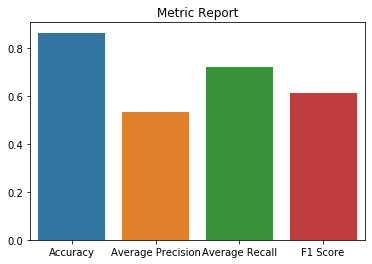

In [395]:
model.displayMetricReport()

# 1.3.1 Experiment 1: Stop-word Filtering

In [396]:
secondTrainData = generateTrainData()
secondTestData = generateTestData()

In [397]:
stopWordModel = BayesModel(secondTrainData, True)
stopWordModel.lexicon.getInformation()


Number Of Unique Words in the lexicon: 9745

------poll------
Number Of Unique Words: 980
Number Of Words: 1248
Title Count: 200 

------story------
Number Of Unique Words: 9097
Number Of Words: 25712
Title Count: 4380 

------ask_hn------
Number Of Unique Words: 747
Number Of Words: 1525
Title Count: 220 

------show_hn------
Number Of Unique Words: 839
Number Of Words: 1550
Title Count: 200 



Lets create the files and test the model

In [398]:
stopWordModel  .createModelFile('../data/stopword-model.txt')
stopWordModel.createClassificationFile('../data/stopword-result.txt', secondTrainData)

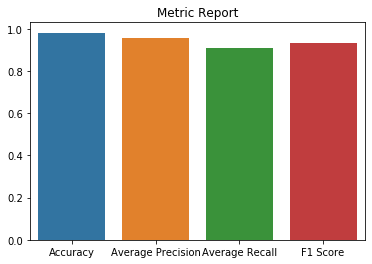

In [399]:
stopWordModel.displayMetricReport()

# 1.3.2 Experiment 2: Word Length Filtering

In [400]:
thirdTrainData = generateTrainData()
thirdTestData = generateTestData()

In [401]:
lengthModel = BayesModel(thirdTrainData, True, 2, 9)

In [402]:
lengthModel.createModelFile('../data/length-vocabulary.txt')
lengthModel.createClassificationFile('../data/length-result.txt.txt',thirdTestData)

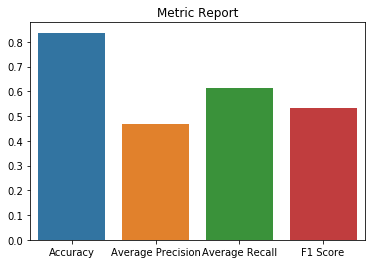

In [403]:
lengthModel.displayMetricReport()

In [404]:
lengthModel.printReport()

Accuracy: 0.8366
Average Precision: 0.4684
Average Recall: 0.6119
F1 score: 0.5306


# 1.3.3 Experiment 3: Infrequent Word Filtering

In [405]:
FourthTrainData = generateTrainData()
FourthTestData = generateTestData()

In [406]:
filteredModel = BayesModel(FourthTrainData)
filteredModel.removeLeastFrequent(50,True)
filteredModel.lexicon.getInformation()


Number Of Unique Words in the lexicon: 7088

------poll------
Number Of Unique Words: 848
Number Of Words: 848
Title Count: 200 

------story------
Number Of Unique Words: 5451
Number Of Words: 5451
Title Count: 4380 

------ask_hn------
Number Of Unique Words: 605
Number Of Words: 605
Title Count: 220 

------show_hn------
Number Of Unique Words: 686
Number Of Words: 686
Title Count: 200 



In [407]:
filteredModel.createModelFile('../data/filtered-vocabulary.txt')
filteredModel.createClassificationFile('../data/filtered-result.txt.txt',FourthTestData)

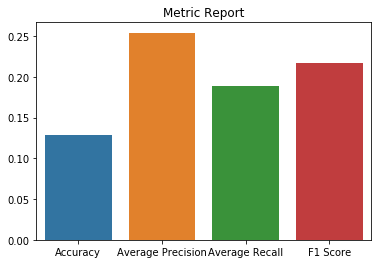

In [408]:
filteredModel.displayMetricReport()

## Lets plot the Diffenrences based on the change in vocabulary size

In [409]:
fifthTrainData = generateTrainData()
fifthTestData = generateTestData()

In [410]:
numberOfWords = []
numberOfUniqueWords = []
accuracy = []
precision = []
recall = []
f1 = []
percentage = range(60)
for i in percentage:
    filteredModel = BayesModel(fifthTrainData)
    filteredModel.removeLeastFrequent(i,True)
    filteredModel.testModel(fifthTestData)
    numberOfWords.append(filteredModel.getTotalNumberOfWords())
    numberOfUniqueWords.append(filteredModel.getNumberOfUniqueWords())
    results = filteredModel.getMetrics()[1]
    accuracy.append(results[0])
    precision.append(results[1])
    recall.append(results[2])
    f1.append(results[3])

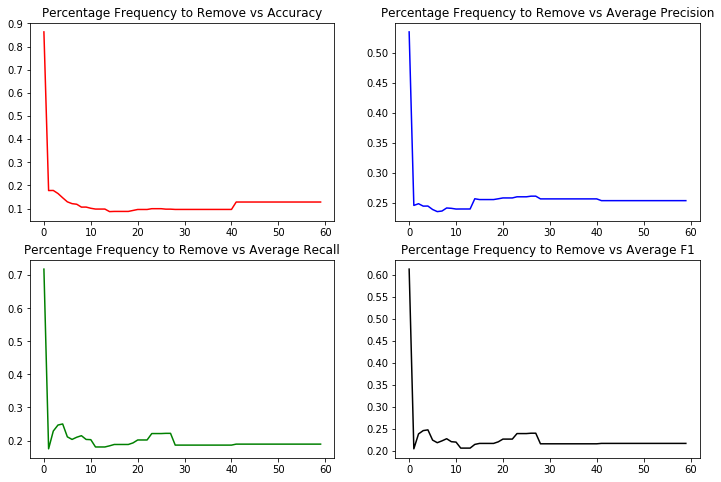

In [411]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(12,8))

ax1.plot(percentage,accuracy, 'r')
ax1.set_title('Percentage Frequency to Remove vs Accuracy')

ax2.plot(percentage,precision, 'b')
ax2.set_title('Percentage Frequency to Remove vs Average Precision')

ax3.plot(percentage,recall, 'g')
ax3.set_title('Percentage Frequency to Remove vs Average Recall')

ax4.plot(percentage,f1, 'k')
ax4.set_title('Percentage Frequency to Remove vs Average F1')

plt.show()

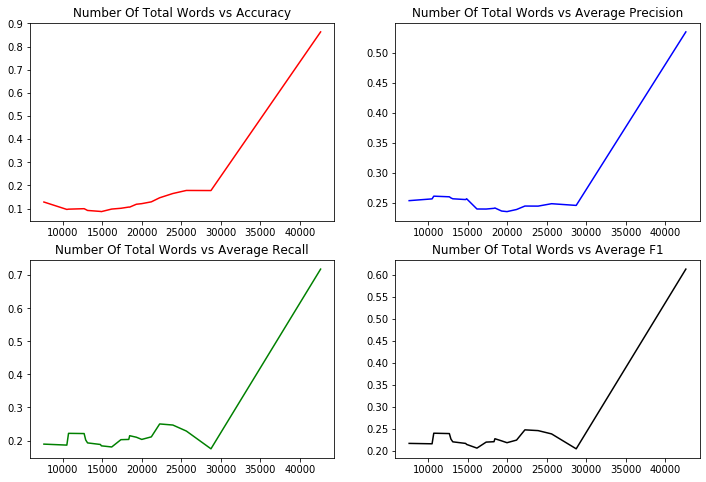

In [412]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(12,8))

ax1.plot(numberOfWords,accuracy, 'r')
ax1.set_title('Number Of Total Words vs Accuracy')

ax2.plot(numberOfWords,precision, 'b')
ax2.set_title('Number Of Total Words vs Average Precision')

ax3.plot(numberOfWords,recall, 'g')
ax3.set_title('Number Of Total Words vs Average Recall')

ax4.plot(numberOfWords,f1, 'k')
ax4.set_title('Number Of Total Words vs Average F1')

plt.show()

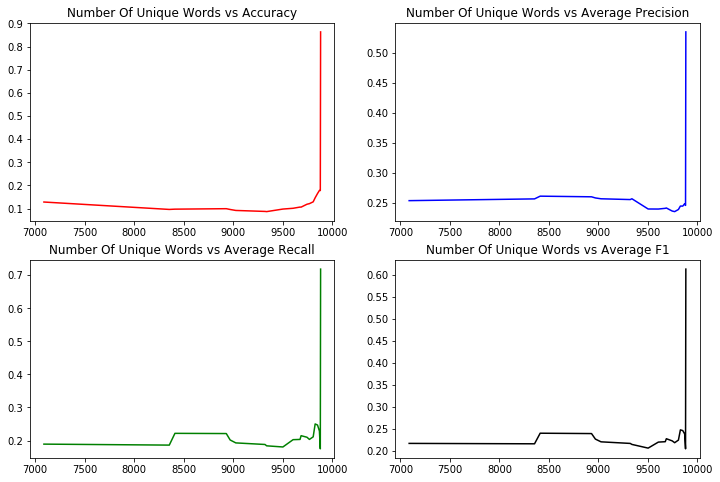

In [413]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(12,8))

ax1.plot(numberOfUniqueWords,accuracy, 'r')
ax1.set_title('Number Of Unique Words vs Accuracy')

ax2.plot(numberOfUniqueWords,precision, 'b')
ax2.set_title('Number Of Unique Words vs Average Precision')

ax3.plot(numberOfUniqueWords,recall, 'g')
ax3.set_title('Number Of Unique Words vs Average Recall')

ax4.plot(numberOfUniqueWords,f1, 'k')
ax4.set_title('Number Of Unique Words vs Average F1')

plt.show()